In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

### Загрузка данных

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sbmt = pd.read_csv('sample_submission_most_popular.csv')

In [3]:
train.head()

,id,movie,dialogue,genres
0,0,0,I thought you were in a meeting--? <BR> I am. With you.,"[u'drama', u'romance']"
1,1,1,Are you sure you're okay? You're pale. <BR> I feel like shit. Me and my frigging nosebleeds. <BR> I'm taking you to the doctor when we get home and I don't want to hear any arguments. <BR> Would you be bummed out if I didn't go to Chicago with you? <BR> No not at all. Sure. You're right. You...,[u'drama']
2,2,2,Go on! Get out! <BR> Mom look don't say anything. First of all I'm not pregnant.,[u'comedy']
3,3,3,I could have lost my fucking hands. <BR> That would have kept you out of the Magic Circle. Which was presumably the idea. These are about Nix.,"[u'mystery', u'thriller']"
4,4,4,Stick with me on this Gloria. I need you... <BR> And if the teeth aren't Suzie's? You'll give this up? <BR> If I'm wrong about those teeth -- it's a promise.,"[u'crime', u'thriller']"


почистим наименования жанров

In [4]:
train['genres'] = train['genres'].apply(lambda x: x.strip('[]').replace("u'","").replace("'", "").split(', '))

In [5]:
train.head()

,id,movie,dialogue,genres
0,0,0,I thought you were in a meeting--? <BR> I am. With you.,"[drama, romance]"
1,1,1,Are you sure you're okay? You're pale. <BR> I feel like shit. Me and my frigging nosebleeds. <BR> I'm taking you to the doctor when we get home and I don't want to hear any arguments. <BR> Would you be bummed out if I didn't go to Chicago with you? <BR> No not at all. Sure. You're right. You...,[drama]
2,2,2,Go on! Get out! <BR> Mom look don't say anything. First of all I'm not pregnant.,[comedy]
3,3,3,I could have lost my fucking hands. <BR> That would have kept you out of the Magic Circle. Which was presumably the idea. These are about Nix.,"[mystery, thriller]"
4,4,4,Stick with me on this Gloria. I need you... <BR> And if the teeth aren't Suzie's? You'll give this up? <BR> If I'm wrong about those teeth -- it's a promise.,"[crime, thriller]"


Найдем все жанры

In [7]:
genres = [] 

# extract genres
for i in train['genres']: 
    for j in i:
        genres.append([j])

In [8]:
# all_genres = set(genres)
# len(set(all_genres))
all_genres = sum(genres,[])
len(set(all_genres))

20

In [9]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [10]:
all_genres_df

,Genre,Count
0,drama,18112
1,romance,5188
2,comedy,7483
3,mystery,2668
4,thriller,12641
5,crime,5388
6,action,6144
7,fantasy,911
8,war,542
9,sci-fi,3166


Количество жанров во всем датасете

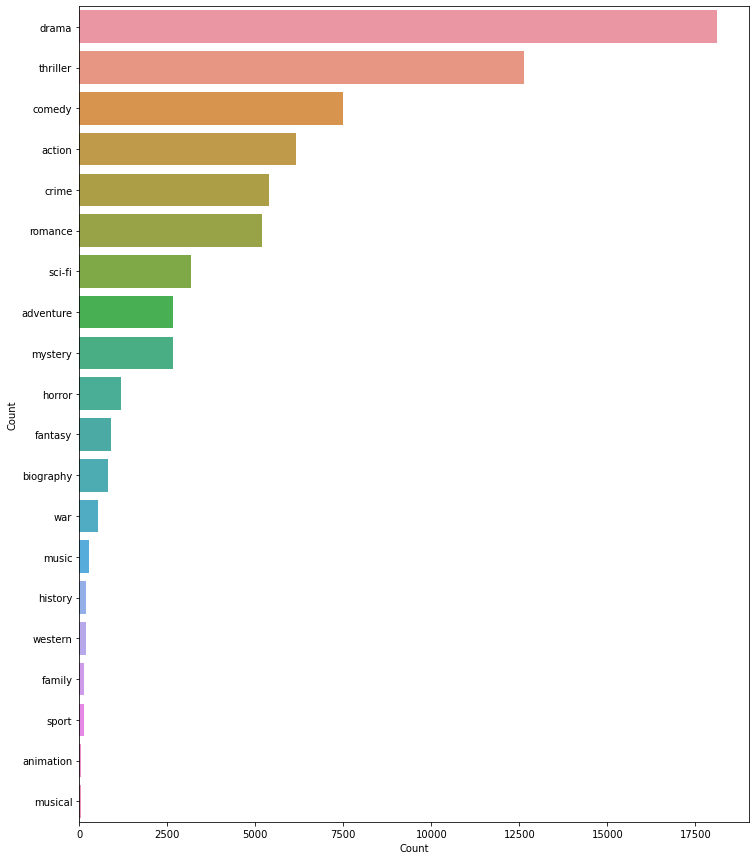

In [11]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

### Предобработка текста

In [12]:
def clean_text(text):
    # удалить бэкслеш и апостроф
    text = re.sub("\'", "", text) 
    # удалить все, не считая алфавита
    text = re.sub("[^a-zA-Z]"," ",text) 
    # удалить пробелы
    text = ' '.join(text.split()) 
    # приведение к нижнему регистру
    text = text.lower() 
    
    return text

In [13]:
train['dialogue'] = train['dialogue'].apply(lambda x: clean_text(x))
test['dialogue'] = test['dialogue'].apply(lambda x: clean_text(x))

In [14]:
test.head()

,id,dialogue
0,0,boy did you see the way mama whopped that deputy with her shoe knocked the gun right out br i dont want you hanging around there hear
1,1,gordon the insurance people are balking on the logging trucks br tell those spineless toads well self insure if they dont write it you fire vice presidents and nothing changes you eating twinkies today bud or are you schtupping some stewardess
2,2,very fancy did you design the bottle br who else im the one who runs the estates while youre here risking everything we have for the glory of rome or for the glory of you br im a soldier were at war i cant stay home tending the damned olive groves br we dont need your help were doing great on ou...
3,3,it makes me so mad steven schwimmer ready to strike the exterminating angel br its all worked out theyll lose tonight then theyll lose tomorrow i see it with stunning clarity br its your best play nicky br theyll lose because theyre my team br he will absolutely hate it
4,4,something ought to loosen him up how comes were going to el paso rudy br i just want to find a suitcase


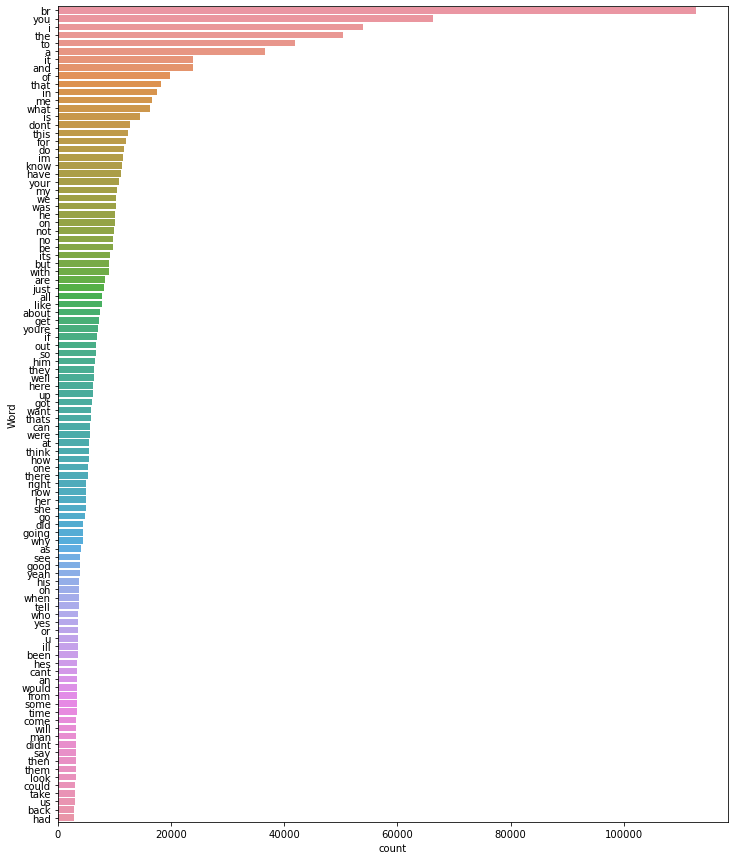

In [16]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  
# print 100 most frequent words 
freq_words(train['dialogue'], 100)

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Удалим все стоп-слова

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


In [19]:
train['dialogue'] = train['dialogue'].apply(lambda x: remove_stopwords(x))
test['dialogue'] = test['dialogue'].apply(lambda x: remove_stopwords(x))

In [20]:
train.head()

,id,movie,dialogue,genres
0,0,0,thought meeting br,"[drama, romance]"
1,1,1,sure youre okay youre pale br feel like shit frigging nosebleeds br im taking doctor get home dont want hear arguments br would bummed didnt go chicago br sure youre right fly home get rest br nice first impression nose bleed front parents br oh g embarrassing wanted shoot br oh werent bad mean ...,[drama]
2,2,2,go get br mom look dont say anything first im pregnant,[comedy]
3,3,3,could lost fucking hands br would kept magic circle presumably idea nix,"[mystery, thriller]"
4,4,4,stick gloria need br teeth arent suzies youll give br im wrong teeth promise,"[crime, thriller]"


### Преобразование текста

In [21]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train['genres'])

y = multilabel_binarizer.transform(train['genres'])

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [23]:
xtrain, xval, ytrain, yval = train_test_split(train['dialogue'], y, test_size=0.2, random_state=9)

In [24]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### Построение модели

In [27]:
lr = LogisticRegression(max_iter=2000)
clf = OneVsRestClassifier(lr)

In [28]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000))

In [29]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [31]:
multilabel_binarizer.inverse_transform(y_pred)[:10]

[('thriller',),
 ('drama',),
 (),
 ('drama',),
 ('drama',),
 ('crime',),
 ('drama',),
 ('thriller',),
 ('drama',),
 ('drama',)]

In [32]:
f1_score(yval, y_pred, average="micro")

0.562285606879376

In [33]:
y_pred_prob = clf.predict_proba(xval_tfidf)

In [34]:
t = 0.3 # уменьшим порог
y_pred_new = (y_pred_prob >= t).astype(int)

In [35]:
f1_score(yval, y_pred_new, average="micro")

0.6449983766819378

In [89]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

Обучим весь датасет

In [36]:
X_train = train['dialogue']
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(test['dialogue'])

In [37]:
clf.fit(X_train_tfidf, y)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000))

In [38]:
pred = clf.predict(X_test_tfidf)

In [39]:
y_pred_prob = clf.predict_proba(X_test_tfidf)

In [40]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [41]:
y_pred_new

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [42]:
ans = multilabel_binarizer.inverse_transform(y_pred_new)

In [43]:
# outfile = open("ans.csv", "w")
# print("id,genres", file=outfile)
# for i in range(len(test['id'])):
#     genres_string = " ".join(list(ans[i]))
#     print(str(i), genres_string, sep=",", file=outfile)
# outfile.close()

In [44]:
output = pd.DataFrame(columns = ['genres'])
for i in range(len(ans)):
    to_out = ''
    for j in range(len(ans[i])):
#         print(ans[i][j], end=' ')
        to_out += ans[i][j] + ' '
    if len(to_out) == 0:
        output.loc[i] = ['history western sport family animation musical ']
    else:
        output.loc[i] = [to_out]



In [45]:
output

,genres
0,crime drama
1,drama
2,drama
3,drama
4,action thriller
...,...
9398,comedy drama romance
9399,comedy drama romance
9400,comedy drama romance
9401,drama


In [50]:
# wsad = output.copy()
# wsad1 = test[['id']]
# wsad1 = pd.concat([wsad1, wsad], axis=1)
# wsad1.to_csv("ans7.csv", index=False)